In [2]:
import numpy as np 
import cupy as cp
import cupyx as cpx
import time
import cv2
import zarr

from gpu_acc_utils import *
from cupyx.scipy.interpolate import RegularGridInterpolator as reg_interp

In [3]:
intrinsics = np.array([3040, # number of pixel columns
                       4056, # number of pixel rows
                       1503.0136, # U component of principal point
                       2163.4301, # V component of principal point
                       2330.4972, # U component of focal length
                       2334.0017, # V component of focal length
                       -0.3587, # radial distortion 
                       0.1388, # radial distortion
                       -0.0266, # radial distortion
                       -0.0046, # tangential distortion
                       0.0003 # tangential distortion
                       ])

In [4]:
extrinsics = np.array([712159.597863065, # camera x in world
                       33136.9994153273, # camera y in world
                       3.72446811607855, # camera elev in world
                       1.30039127961854, # azimuth
                       1.02781393967485, # tilt
                       -0.160877893129538 # roll/swing
                       ])

In [5]:
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from rectification_utils import *
import open3d as o3d
import laspy
import lazrs
import laszip

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


(3, 35549)
Directory to store grids already exists: data/generated_grids


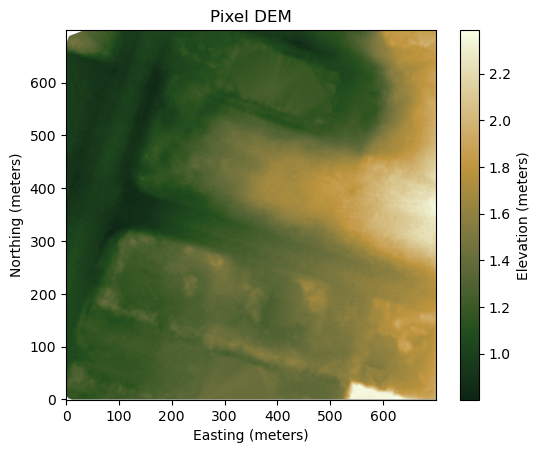

In [63]:
file_path = '/home/rmccune/depth_mapping/data/lidar/Job1051007_34077_04_88.laz'

las = laspy.read(file_path)

pts_mask = las.classification == 2 # land classification (1 is unclassified points)

xyz_t = np.vstack([las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]])

building_xyz_m = xyz_t * 0.3048 

point_cloud_df = pd.DataFrame(building_xyz_m.T, columns=['x', 'y', 'z'])

max_x_extent = 712230
min_x_extent = 712160
max_y_extent = 33170
min_y_extent = 33100

# Filter the DataFrame
filtered_df = point_cloud_df[
    (point_cloud_df['x'] >= min_x_extent) & (point_cloud_df['x'] <= max_x_extent) &
    (point_cloud_df['y'] >= min_y_extent) & (point_cloud_df['y'] <= max_y_extent)
]

x = filtered_df['x'].values
y = filtered_df['y'].values
z = filtered_df['z'].values

resolution = 0.10 # meters

pts_array = np.array([x, y, z])

print(pts_array.shape)

grid_dir = 'data/generated_grids'
grid_x, grid_y, grid_z = gen_grid(min_x_extent, max_x_extent, min_y_extent, max_y_extent, resolution, pts_array, dir=grid_dir)

grid_x = grid_x.T
grid_y = grid_y.T
grid_z = grid_z.T

# Get the topo colormap from cmocean
cmap = cmocean.cm.topo

# Truncate the colormap to get only the above-land portion
# Assuming "above land" is the upper half of the colormap
above_land_cmap = LinearSegmentedColormap.from_list(
    'above_land_cmap', cmap(np.linspace(0.5, 1, 256))
)

plt.imshow(grid_z, origin='lower', cmap=above_land_cmap)
plt.colorbar(label='Elevation (meters)')
plt.title('Pixel DEM')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

# Save the figure before showing it
# plt.savefig('/home/rmccune/depth_mapping/plots/pixel_DEM_1cm_res_CB_03.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [25]:
from rectification_utils import *

In [37]:
start_time = time.perf_counter()

ir = mergeRectify('CAM_CB_03_20231008174225.jpg', intrinsics, extrinsics, grid_x, grid_y, grid_z)

end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Function execution time: {elapsed_time:.6f} seconds")

Function execution time: 0.213308 seconds


/home/rmccune/depth_mapping/rectification_utils.py:243: RuntimeWarning: invalid value encountered in cast
  Ud = Ud.astype(int)
/home/rmccune/depth_mapping/rectification_utils.py:244: RuntimeWarning: invalid value encountered in cast
  Vd = Vd.astype(int)
/home/rmccune/depth_mapping/rectification_utils.py:247: RuntimeWarning: invalid value encountered in cast
  ir = np.array(ir, dtype=np.uint8)


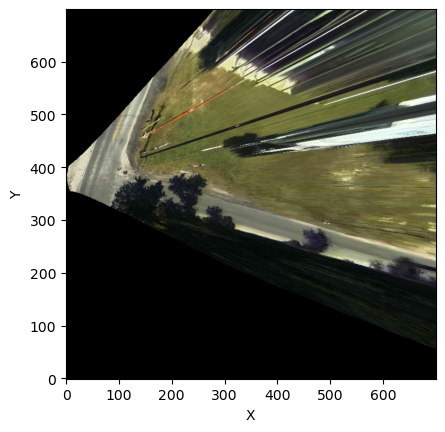

In [38]:
plt.imshow(ir)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [64]:
grid_x_gpu = cp.array(grid_x)
grid_y_gpu = cp.array(grid_y)
grid_z_gpu = cp.array(grid_z)

intrinsics_gpu = cp.array(intrinsics)
extrinsics_gpu = cp.array(extrinsics)

# start_time = time.perf_counter()

# ir_gpu = mergeRectify_gpu('CAM_CB_03_20231008174225.jpg', intrinsics_gpu, extrinsics_gpu, grid_x_gpu, grid_y_gpu, grid_z_gpu)

# end_time = time.perf_counter()

# elapsed_time = end_time - start_time
# print(f"Function execution time: {elapsed_time:.6f} seconds")

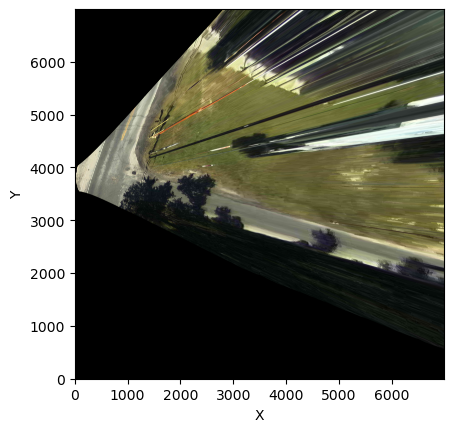

In [10]:
show_ir_gpu = cp.asnumpy(ir_gpu)
plt.imshow(show_ir_gpu)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [75]:
images_folder = '/home/rmccune/depth_mapping/data/CB03_12272023/orig_images'
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/CB03_12272023/orig_image_rects'

mergeRectifyFolder_gpu(images_folder, intrinsics, extrinsics, grid_x_gpu, grid_y_gpu, grid_z_gpu, zarr_store_path)

<Group file:///home/rmccune/depth_mapping/data/zarr/CB03_12272023/orig_image_rects>

In [76]:
labels_folder = '/home/rmccune/depth_mapping/data/CB03_12272023/labels'
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/CB03_12272023/labels_rects'

mergeRectifyLabelsFolder_gpu(labels_folder, intrinsics_gpu, extrinsics_gpu, grid_x_gpu, grid_y_gpu, grid_z_gpu, zarr_store_path)

<Group file:///home/rmccune/depth_mapping/data/zarr/CB03_12272023/labels_rects>

In [10]:
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/labels_rects'

img_id = "CAM_CB_03_20231217123625_predseg_labels_rectified"
img_store_path = f"{zarr_store_path}/{img_id}"

# Open the Zarr store
img_store = zarr.open(img_store_path, mode="r")

In [11]:
labels = img_store[:]

np.unique(labels)

array([0, 1, 2, 3, 5], dtype=uint8)

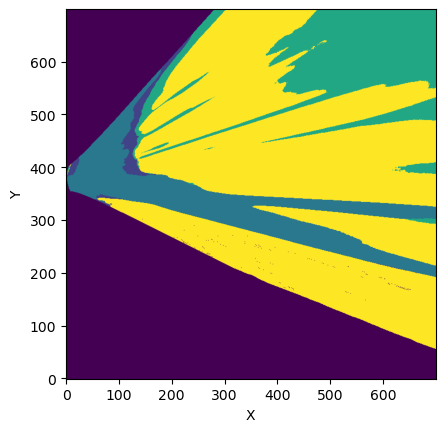

In [12]:
plt.imshow(labels, cmap='viridis')
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

## Depth Mapping

In [31]:
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/labels_rects'

img_id = "CAM_CB_03_20231217150625_predseg_labels_rectified"
img_store_path = f"{zarr_store_path}/{img_id}"

# Open the Zarr store
img_store = zarr.open(img_store_path, mode="r")
array = img_store[:]


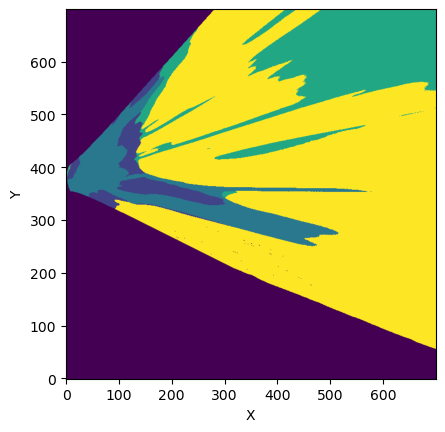

In [32]:
plt.imshow(array, cmap='viridis')
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [33]:
gpu_label_array = cp.array(array)

labels_squeezed = gpu_label_array.squeeze()
mask = (labels_squeezed == 1)
masked_elevations = cp.where(mask, grid_z_gpu, cp.nan)

masked_labels = cp.where(gpu_label_array == 1, gpu_label_array, 0)
masked_labels = cp.squeeze(masked_labels)

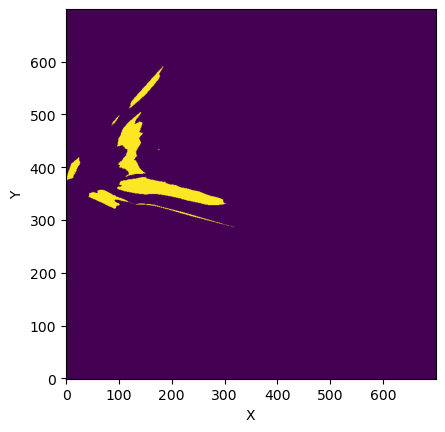

In [34]:
masked_labels_np = cp.asnumpy(masked_labels)
plt.imshow(masked_labels_np, cmap='viridis')
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [35]:
from cupyx.scipy.ndimage import binary_closing
from cupyx.scipy.ndimage import label

In [36]:
closed_data = binary_closing(masked_labels, structure=cp.ones((3, 3)))
labeled_data, num_features = label(closed_data)

min_size = 500  # Minimum size of a pond
unique, counts = cp.unique(labeled_data, return_counts=True)
small_ponds = unique[counts < min_size]  # Identify small ponds
labeled_data[cp.isin(labeled_data, small_ponds)] = 0 

# Reapply the label function to relabel the remaining ponds
labeled_data, num_features = label(labeled_data)

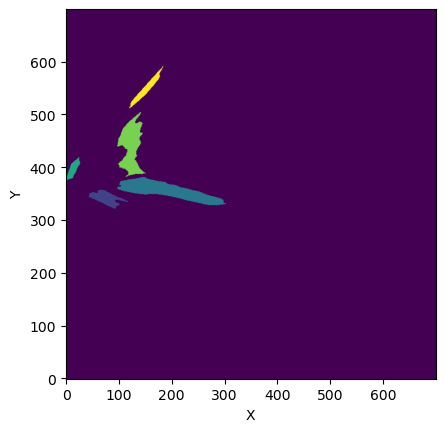

In [37]:
masked_labels_np = cp.asnumpy(labeled_data)
plt.imshow(masked_labels_np, cmap='viridis')
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [38]:
num_features = cp.max(labeled_data)  # The highest label after relabeling is the number of features

labels_squeezed = gpu_label_array.squeeze()
mask = (labels_squeezed == 1)
masked_elevations = cp.where(mask, grid_z_gpu, 0)  # Use np.nan or another value for masked entries


# Sample array with labeled ponds (this should be your `labeled_data`)
arr = masked_elevations

unique_ponds = cp.unique(labeled_data)
unique_ponds = unique_ponds[unique_ponds != 0]  # Exclude background label

### Potentially GPU accelerated

In [21]:
import cucim.skimage as cski

In [22]:
pond_contours = {}

for pond_id in unique_ponds:
    
    # Create a binary mask for the current pond
    pond_mask = (labeled_data == pond_id)

    # Replace NaNs with zeros for contour detection
    pond_arr = cp.where(pond_mask, arr, 0)

    # Apply geodesic active contour to find contours
    # init_level_set = cp.zeros_like(pond_arr)
    # init_level_set[pond_mask] = 1  # Initialize the level set with pond areas

    # Geodesic active contour: the 'smoothness' parameter controls the level of smoothness of the contour
    level_set = cski.segmentation.morphological_geodesic_active_contour(pond_arr, num_iter=50, init_level_set='disk', smoothing=1)
    
    contours = cp.column_stack(cp.where(level_set > 0.5))

    pond_contours[pond_id.item()] = contours


### Continuing Current Method

In [39]:
from skimage.measure import find_contours

In [40]:
# Initialize a dictionary to hold contours for each pond
pond_contours = {}

# Step 3: For each pond, extract contours separately
for pond_id in unique_ponds:
    # Create a binary mask for the current pond
    pond_mask = (cp.asnumpy(labeled_data) == pond_id.item())

    # Replace NaNs with zeros for contour detection
    pond_arr = np.where(pond_mask, cp.asnumpy(arr), 0)

    # Find contours for the pond
    contours = find_contours(pond_arr, level=0.5)

    # Store the contours for this pond in the dictionary
    pond_contours[pond_id.item()] = contours

# Step 4: Convert contour coordinates to integer indices and extract values for each pond
contour_pixels_per_pond = {}
contour_values_per_pond = {}

for pond_id, contours in pond_contours.items():
    contour_pixels = []
    contour_values = []

    for contour in contours:
        for point in contour:
            y, x = np.round(point).astype(int)
            if 0 <= x < cp.asnumpy(arr).shape[1] and 0 <= y < cp.asnumpy(arr).shape[0]:  # Ensure indices are within bounds
                contour_pixels.append((x, y))
                contour_values.append(cp.asnumpy(arr)[y, x])

    # Store contour pixels and values for this pond
    contour_pixels_per_pond[pond_id] = np.array(contour_pixels)
    contour_values_per_pond[pond_id] = np.array(contour_values)

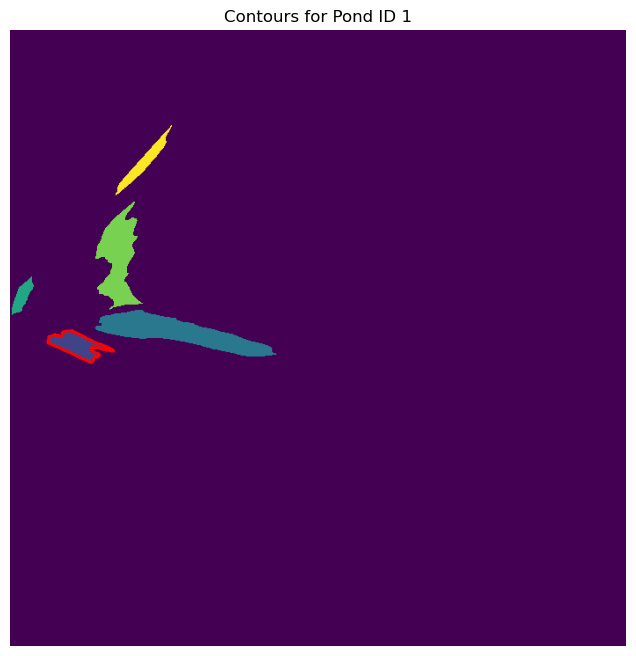

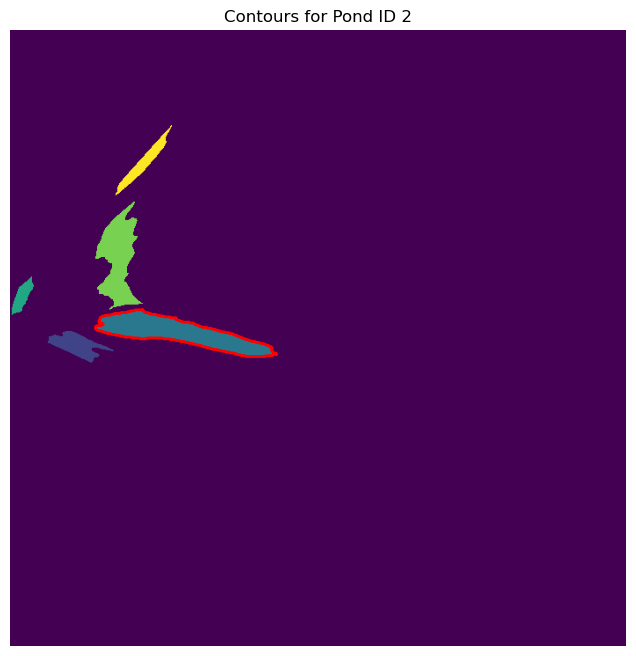

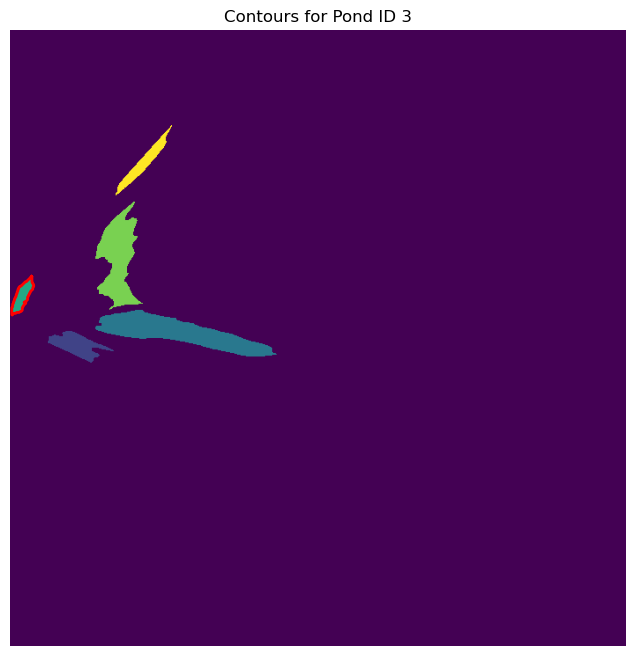

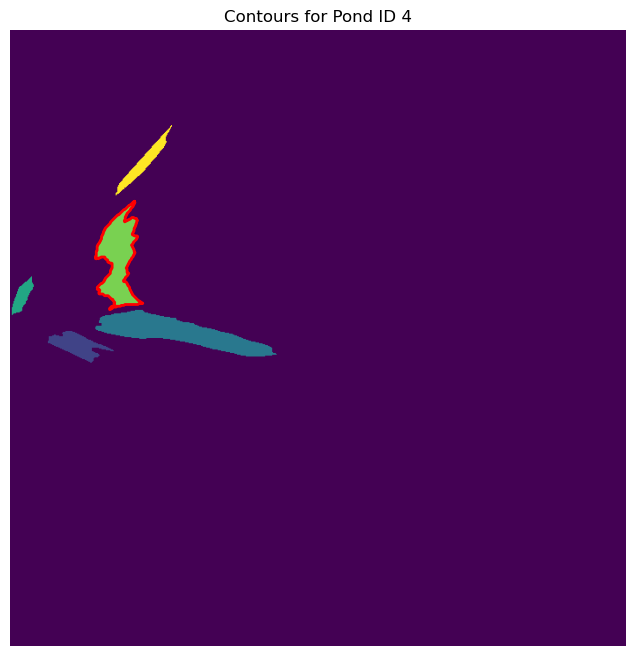

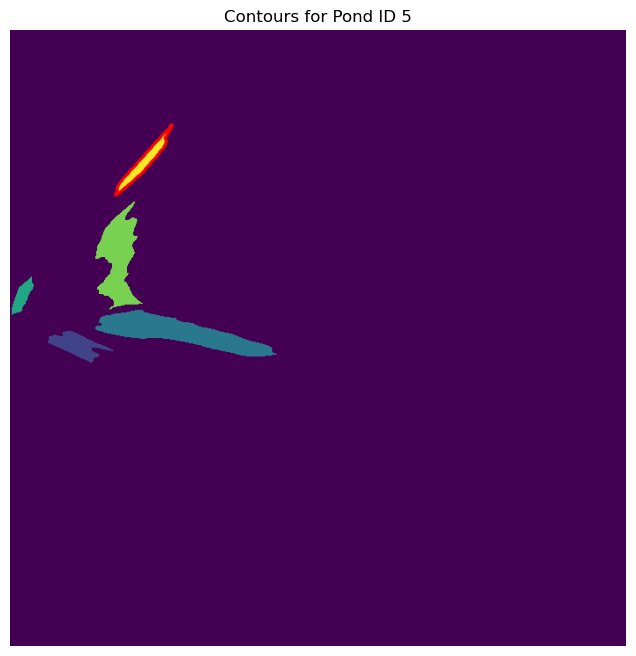

In [42]:
# Plot contours for each pond_id
for pond_id, contours in pond_contours.items():
    # Plot the original image (you can use the 'pond_arr' or 'arr' here)
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
    # plt.imshow(cp.asnumpy(arr), cmap='gray')  # Display the image in grayscale
    plt.imshow(masked_labels_np)

    # Overlay the contours for the current pond_id
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)  # Plot the contour

    # Set title and labels
    plt.title(f'Contours for Pond ID {pond_id}')
    plt.axis('off')  # Optionally hide axes for better visualization
    plt.gca().invert_yaxis()
    plt.show()

In [51]:
type(contour_values_per_pond[1])

numpy.ndarray

In [54]:
pond_depths = {}

# Step 3: For each pond, extract contours separately
for pond_id in unique_ponds:
    # Create a binary mask for the current pond
    pond_mask = (labeled_data == pond_id)

    masked_elevations = cp.where(pond_mask, grid_z_gpu, cp.nan)

    max_elevation = cp.nanmedian(cp.array(contour_values_per_pond[pond_id.item()]))

    depth_map = masked_elevations - max_elevation
    depth_map[depth_map > 0] = 0
    depth_map = cp.abs(depth_map)

    # Store the contours for this pond in the dictionary
    pond_depths[pond_id.item()] = depth_map

# combined_depth_map = pond_depths[1]

In [57]:
pond_depths.keys()

dict_keys([1, 2, 3, 4, 5])

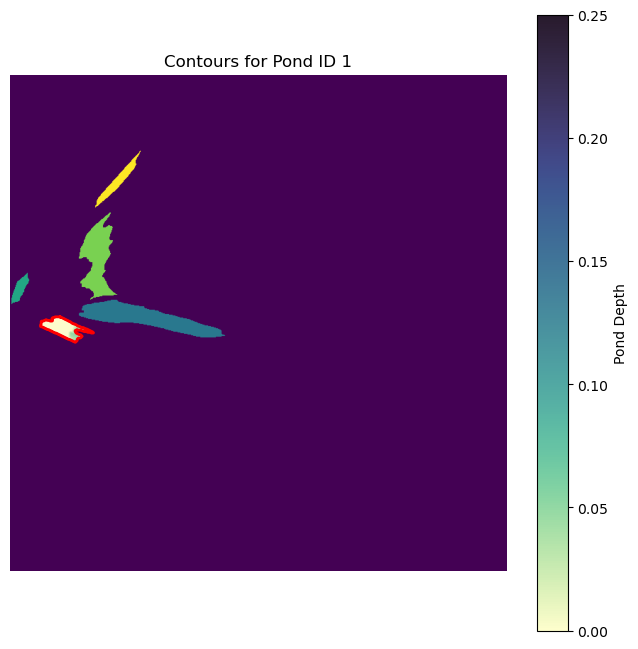

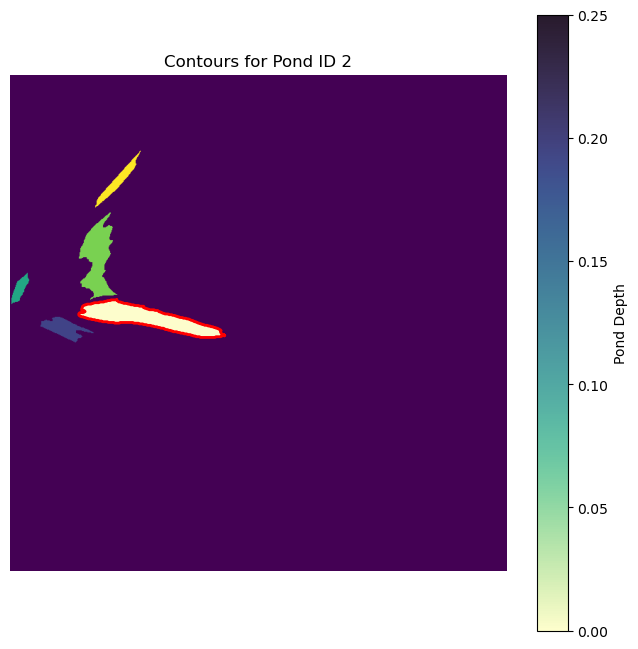

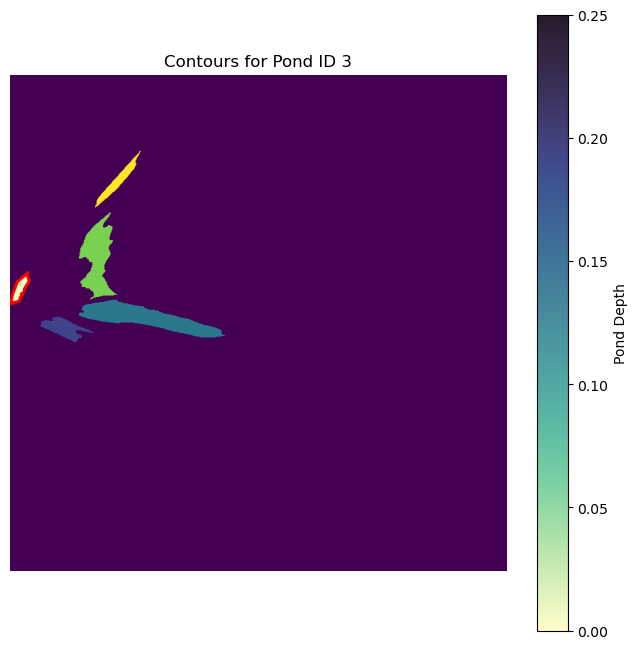

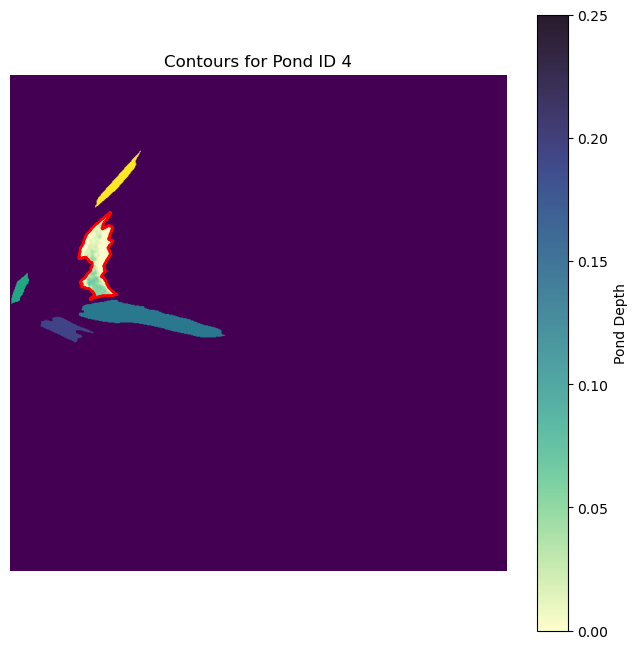

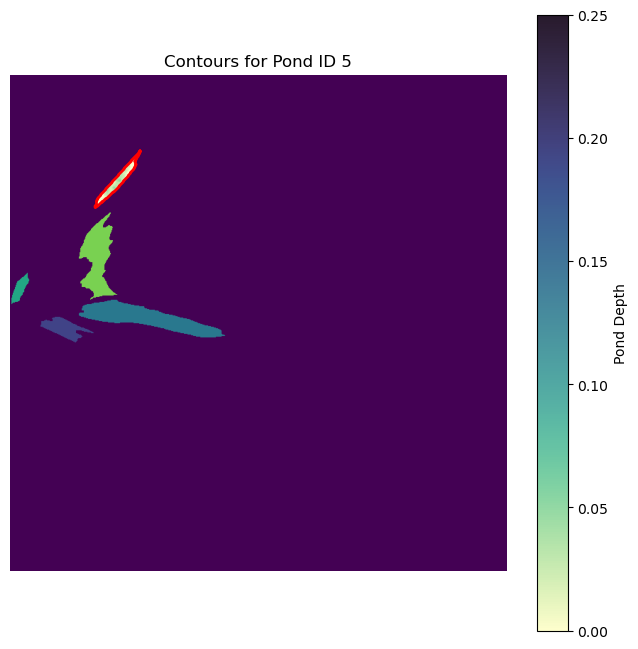

In [63]:
# Plot contours for each pond_id
for pond_id, contours in pond_contours.items():
    # Plot the original image (you can use the 'pond_arr' or 'arr' here)
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
    # plt.imshow(cp.asnumpy(arr), cmap='gray')  # Display the image in grayscale
    plt.imshow(masked_labels_np)

    # Overlay the contours for the current pond_id
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)  # Plot the contour
        
    im = plt.imshow(cp.asnumpy(pond_depths[pond_id]), cmap=cmocean.cm.deep, vmin = 0, vmax = 0.25)
    plt.colorbar(im, label='Pond Depth')

    # Set title and labels
    plt.title(f'Contours for Pond ID {pond_id}')
    plt.axis('off')  # Optionally hide axes for better visualization
    plt.gca().invert_yaxis()
    plt.show()

In [64]:
type(pond_depths[1])

cupy.ndarray

In [65]:
combined_depth_map = pond_depths[1]

# Loop over the remaining arrays, starting from key 2
for i in range(2, len(pond_depths) + 1):
    combined_depth_map = cp.where(cp.isnan(combined_depth_map), pond_depths[i], cp.where(cp.isnan(pond_depths[i]), combined_depth_map, combined_depth_map + pond_depths[i]))

In [70]:
combined_depth_map.size

490000

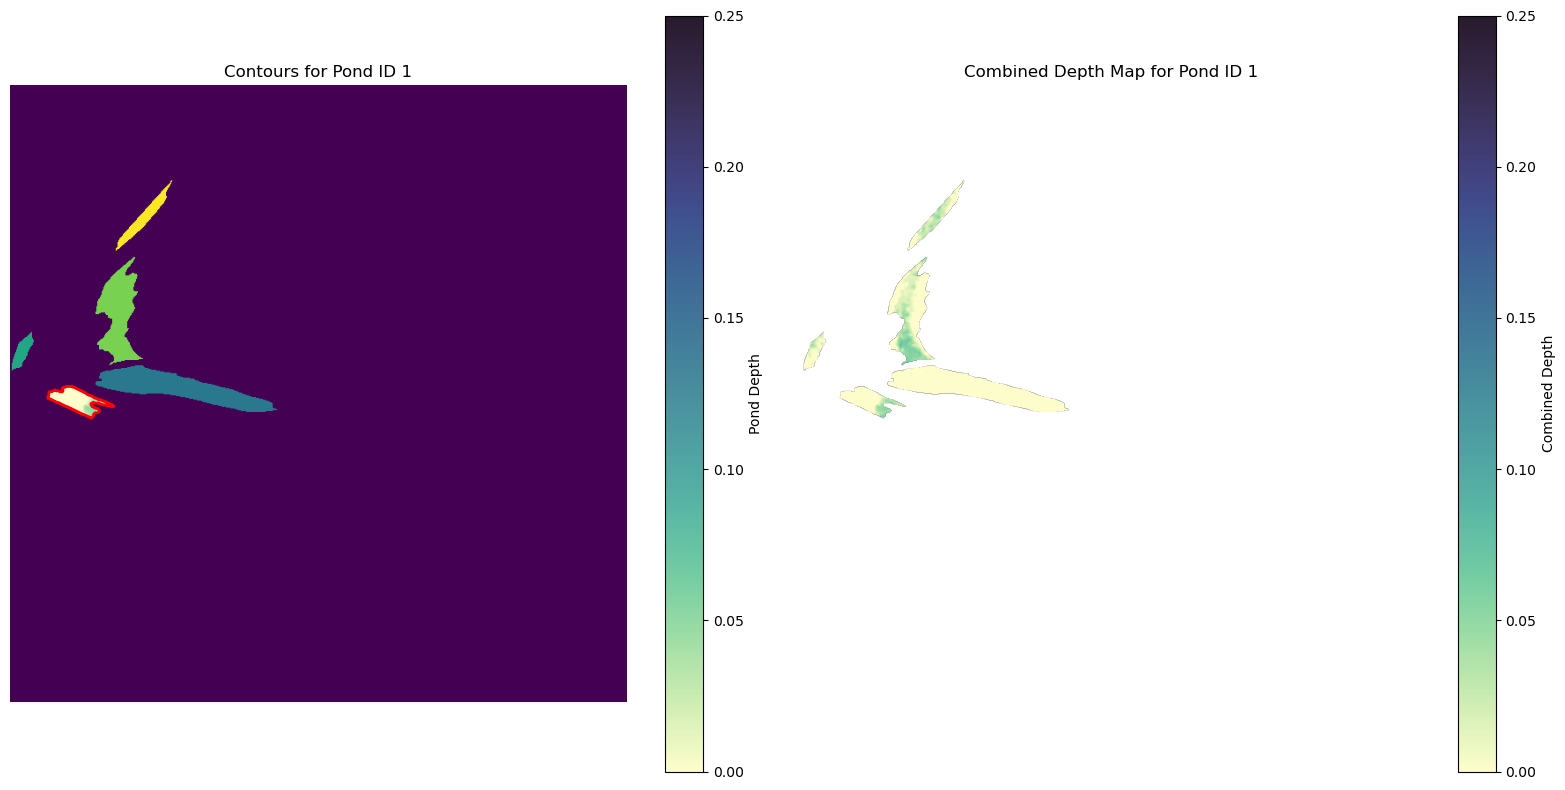

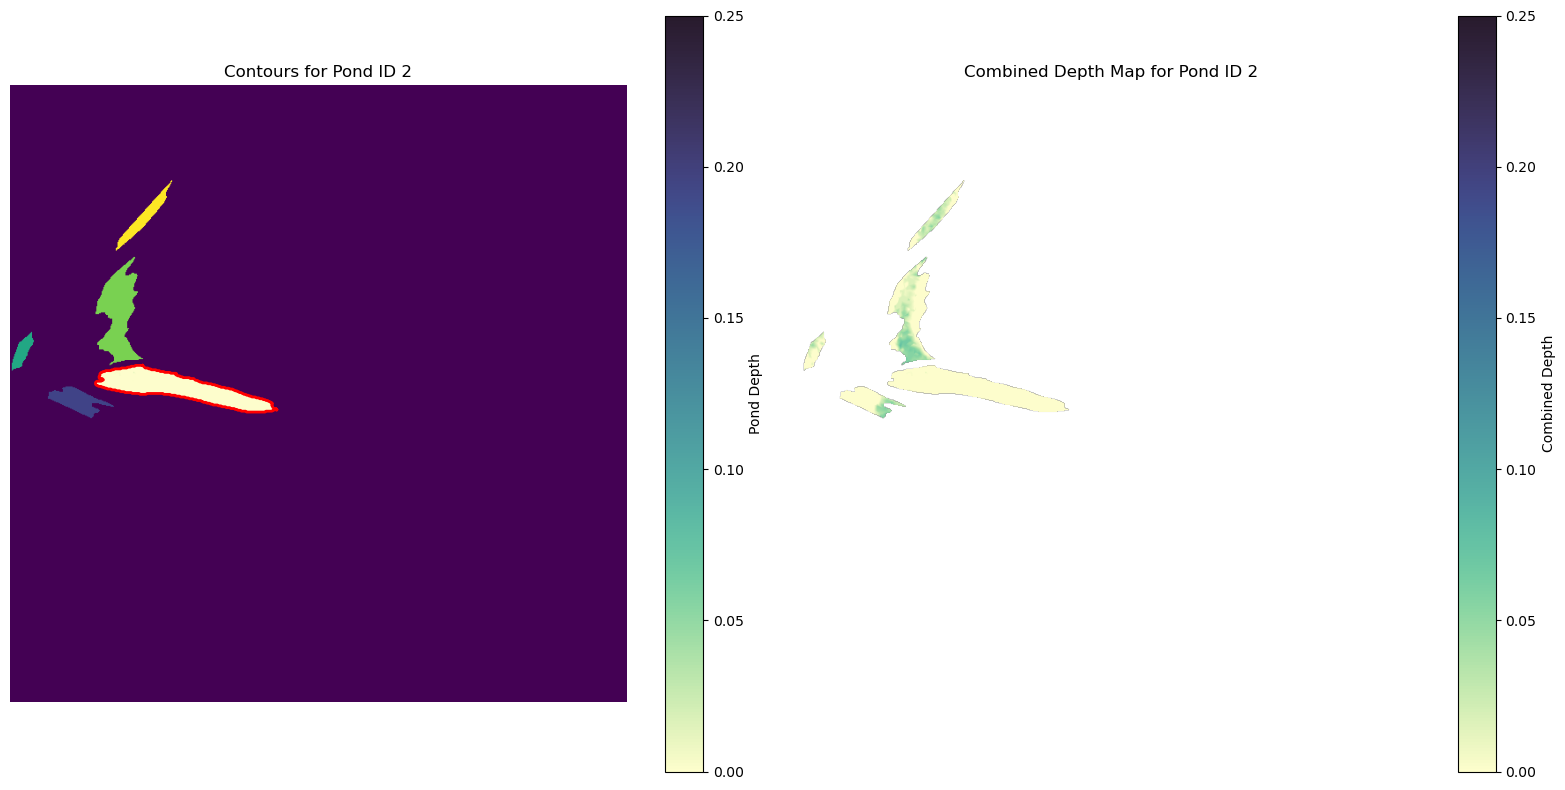

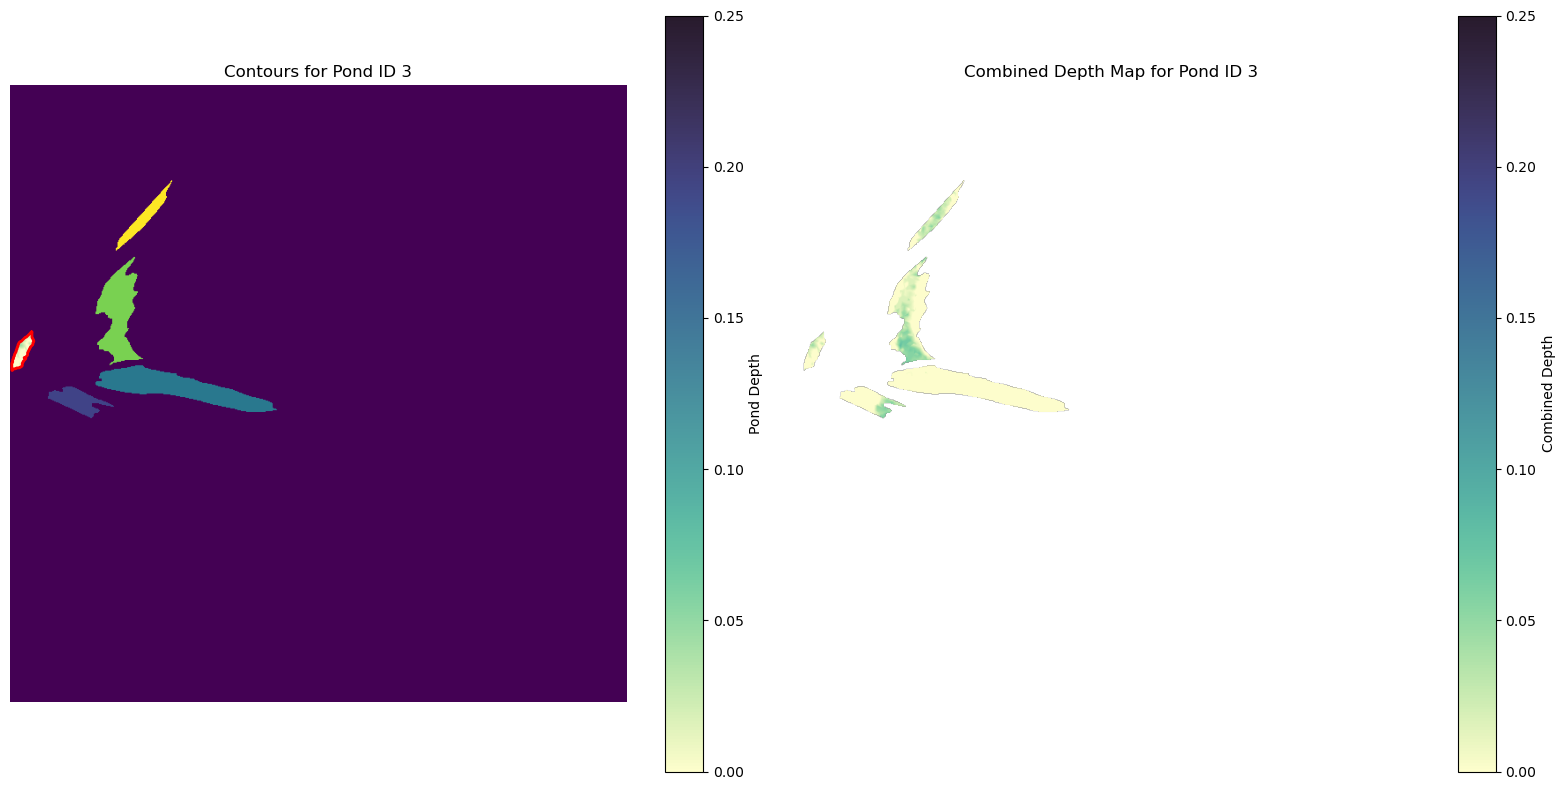

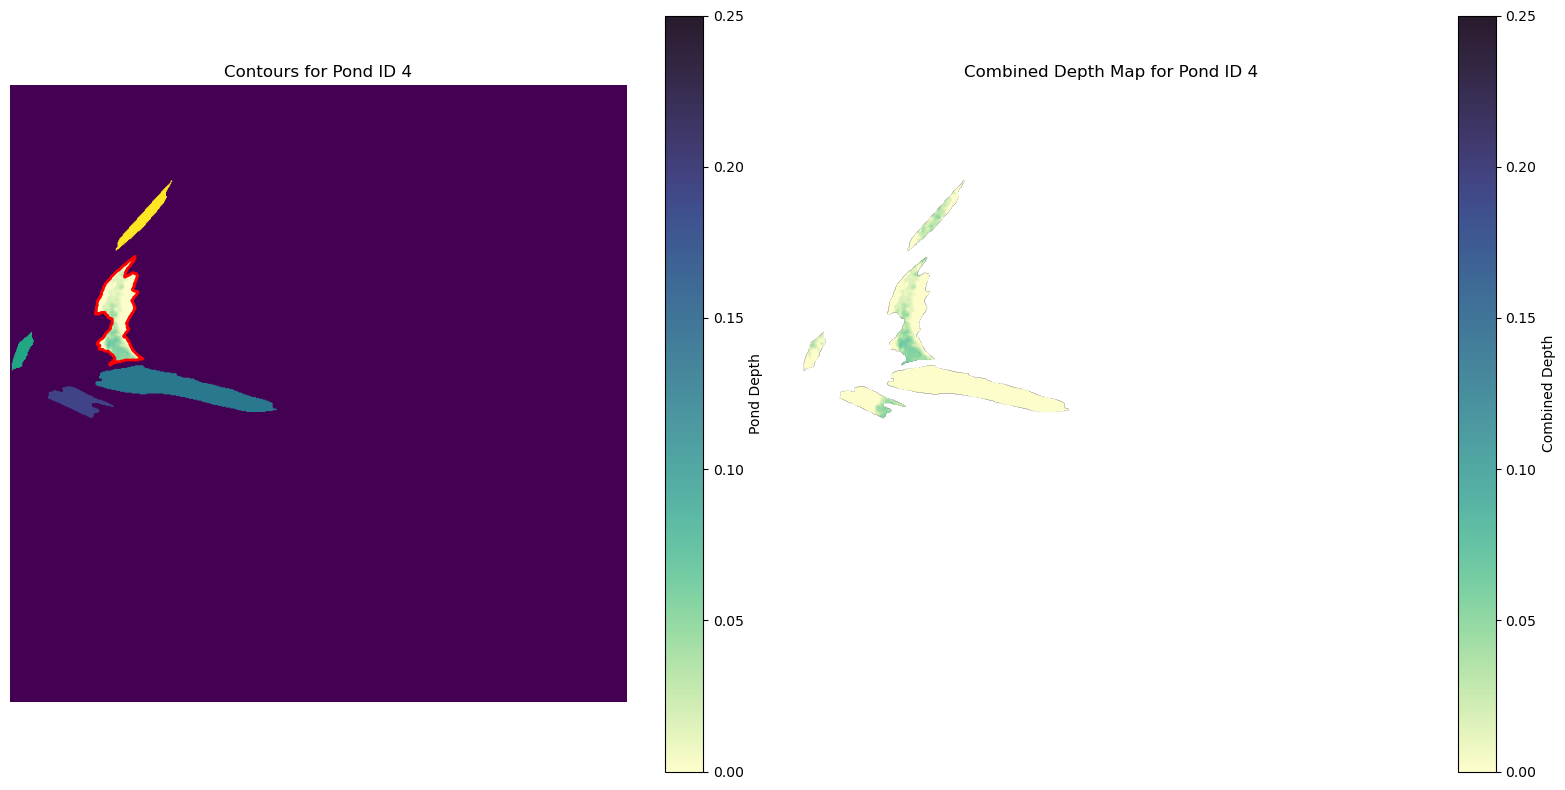

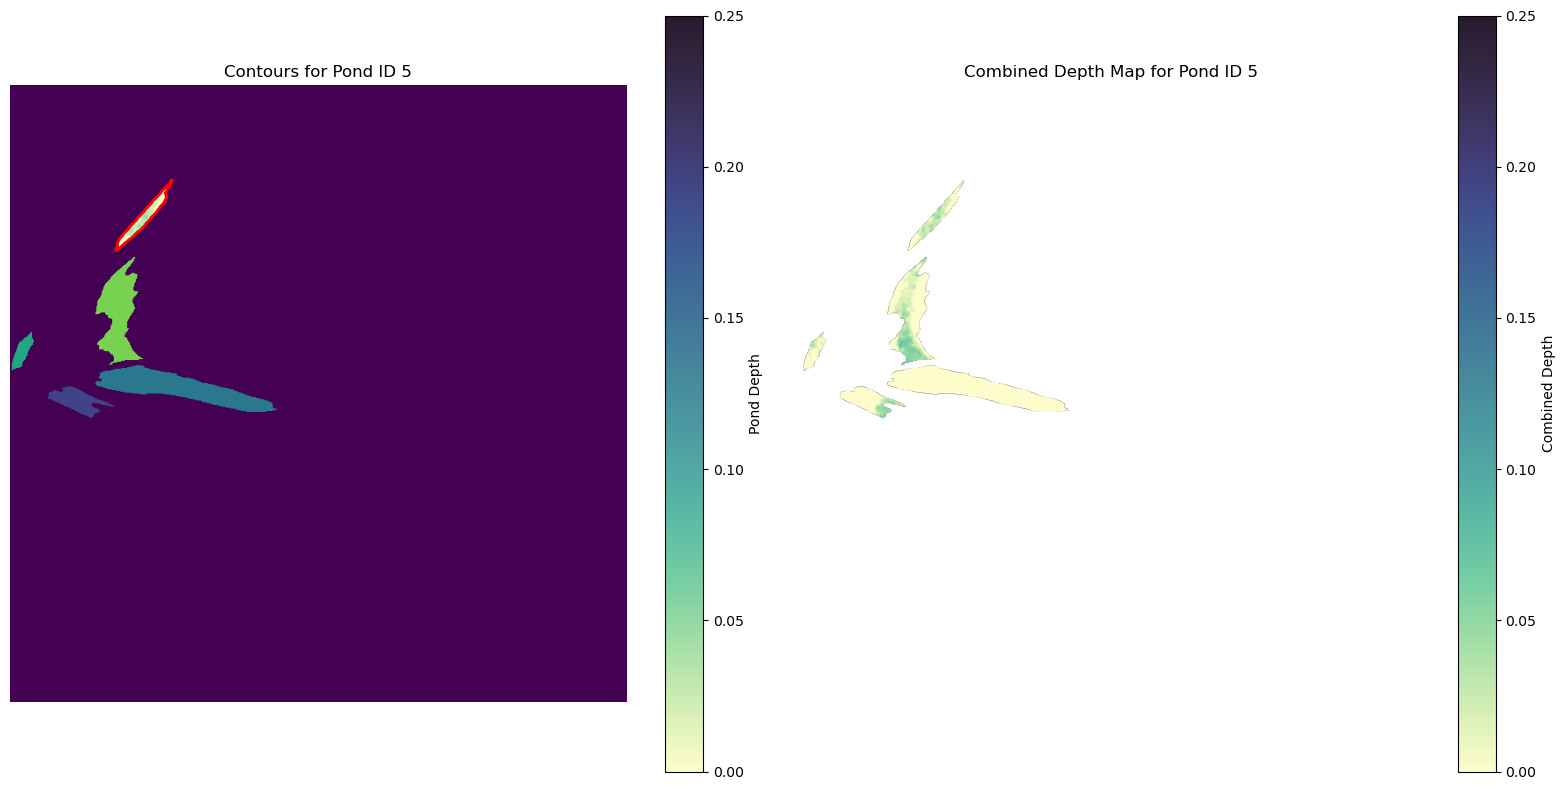

In [71]:
# Plot contours for each pond_id
for pond_id, contours in pond_contours.items():
    # Plot the original image (you can use the 'pond_arr' or 'arr' here)
    plt.figure(figsize=(16, 8))  # Adjust the figure size as needed
    # plt.imshow(cp.asnumpy(arr), cmap='gray')  # Display the image in grayscale
    plt.subplot(1,2,1)
    plt.imshow(masked_labels_np)

    # Overlay the contours for the current pond_id
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)  # Plot the contour
        
    im1 = plt.imshow(cp.asnumpy(pond_depths[pond_id]), cmap=cmocean.cm.deep, vmin = 0, vmax = 0.25)
    plt.colorbar(im1, label='Pond Depth')

    # Set title and labels
    plt.title(f'Contours for Pond ID {pond_id}')
    plt.axis('off')  # Optionally hide axes for better visualization
    plt.gca().invert_yaxis()
    
    plt.subplot(1, 2, 2)  # Second plot (right side)
    im2 = plt.imshow(cp.asnumpy(combined_depth_map), cmap=cmocean.cm.deep, vmin=0, vmax=0.25)
    plt.colorbar(im2, label='Combined Depth')
    plt.title(f'Combined Depth Map for Pond ID {pond_id}')
    plt.axis('off')  # Optionally hide axes for better visualization
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()

In [10]:
from cupyx.scipy.ndimage import binary_closing
from cupyx.scipy.ndimage import label
from skimage.measure import find_contours


In [ ]:
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/labels_rects'

img_id = "CAM_CB_03_20231217150625_predseg_labels_rectified"
img_store_path = f"{zarr_store_path}/{img_id}"

# Open the Zarr store
img_store = zarr.open(img_store_path, mode="r")
array = img_store[:]

In [67]:
def calculate_depth_maps(zarr_dir):

    depth_data = []

    for file_name in os.listdir(zarr_dir):
        if file_name.endswith('_rectified'):
            zarr_store_path = os.path.join(zarr_dir, file_name)
            img_store = zarr.open(zarr_store_path)
            
            array = img_store[:]
            
            print(f"Processing array: {file_name}")

            gpu_label_array = cp.array(array)

            labels_squeezed = gpu_label_array.squeeze()
            mask = (labels_squeezed == 1)
            masked_elevations = cp.where(mask, grid_z_gpu, cp.nan)

            masked_labels = cp.where(gpu_label_array == 1, gpu_label_array, 0)
            masked_labels = cp.squeeze(masked_labels)

            closed_data = binary_closing(masked_labels, structure=cp.ones((3, 3)))
            labeled_data, num_features = label(closed_data)

            min_size = 500  # Minimum size of a pond
            unique, counts = cp.unique(labeled_data, return_counts=True)
            small_ponds = unique[counts < min_size]  # Identify small ponds
            labeled_data[cp.isin(labeled_data, small_ponds)] = 0 

            # Reapply the label function to relabel the remaining ponds
            labeled_data, num_features = label(labeled_data)

            num_features = cp.max(labeled_data)  # The highest label after relabeling is the number of features

            labels_squeezed = gpu_label_array.squeeze()
            mask = (labels_squeezed == 1)
            masked_elevations = cp.where(mask, grid_z_gpu, 0)  # Use np.nan or another value for masked entries


            # Sample array with labeled ponds (this should be your `labeled_data`)
            arr = masked_elevations

            unique_ponds = cp.unique(labeled_data)
            unique_ponds = unique_ponds[unique_ponds != 0]  # Exclude background label


            # Initialize a dictionary to hold contours for each pond
            pond_contours = {}

            # Step 3: For each pond, extract contours separately
            for pond_id in unique_ponds:
                # Create a binary mask for the current pond
                pond_mask = (cp.asnumpy(labeled_data) == pond_id.item())

                # Replace NaNs with zeros for contour detection
                pond_arr = np.where(pond_mask, cp.asnumpy(arr), 0)

                # Find contours for the pond
                contours = find_contours(pond_arr, level=0.5)

                # Store the contours for this pond in the dictionary
                pond_contours[pond_id.item()] = contours

            # Step 4: Convert contour coordinates to integer indices and extract values for each pond
            contour_pixels_per_pond = {}
            contour_values_per_pond = {}

            for pond_id, contours in pond_contours.items():
                contour_pixels = []
                contour_values = []

                for contour in contours:
                    for point in contour:
                        y, x = np.round(point).astype(int)
                        if 0 <= x < cp.asnumpy(arr).shape[1] and 0 <= y < cp.asnumpy(arr).shape[0]:  # Ensure indices are within bounds
                            contour_pixels.append((x, y))
                            contour_values.append(cp.asnumpy(arr)[y, x])

                # Store contour pixels and values for this pond
                contour_pixels_per_pond[pond_id] = np.array(contour_pixels)
                contour_values_per_pond[pond_id] = np.array(contour_values)

            pond_depths = {}

            # Step 3: For each pond, extract contours separately
            for pond_id in unique_ponds:
                # Create a binary mask for the current pond
                pond_mask = (labeled_data == pond_id)

                masked_elevations = cp.where(pond_mask, grid_z_gpu, cp.nan)

                max_elevation = cp.percentile(cp.array(contour_values_per_pond[pond_id.item()]), 95)

                depth_map = masked_elevations - max_elevation
                depth_map[depth_map > 0] = 0
                depth_map = cp.abs(depth_map)

                # Store the contours for this pond in the dictionary
                pond_depths[pond_id.item()] = depth_map

            combined_depth_map = pond_depths[1]

            # Loop over the remaining arrays, starting from key 2
            for i in range(2, len(pond_depths) + 1):
                combined_depth_map = cp.where(cp.isnan(combined_depth_map), pond_depths[i], cp.where(cp.isnan(pond_depths[i]), combined_depth_map, combined_depth_map + pond_depths[i]))
            
            depth_data.append({'image_name': file_name + '_depth_map_median_edge_ponding', 'depth_map': combined_depth_map})

    results = pd.DataFrame(depth_data)

    return results


In [77]:
zarr_directory_path = '/home/rmccune/depth_mapping/data/zarr/CB03_12272023/labels_rects'
results = calculate_depth_maps(zarr_directory_path)

Processing array: CAM_CB_03_20231227133625_predseg_labels_rectified
Processing array: CAM_CB_03_20231227141825_predseg_labels_rectified
Processing array: CAM_CB_03_20231227120625_predseg_labels_rectified
Processing array: CAM_CB_03_20231227125425_predseg_labels_rectified
Processing array: CAM_CB_03_20231227154225_predseg_labels_rectified
Processing array: CAM_CB_03_20231227140025_predseg_labels_rectified
Processing array: CAM_CB_03_20231227145425_predseg_labels_rectified
Processing array: CAM_CB_03_20231227142425_predseg_labels_rectified
Processing array: CAM_CB_03_20231227151225_predseg_labels_rectified
Processing array: CAM_CB_03_20231227143025_predseg_labels_rectified
Processing array: CAM_CB_03_20231227121225_predseg_labels_rectified
Processing array: CAM_CB_03_20231227132425_predseg_labels_rectified
Processing array: CAM_CB_03_20231227123625_predseg_labels_rectified
Processing array: CAM_CB_03_20231227130025_predseg_labels_rectified
Processing array: CAM_CB_03_20231227144225_preds

In [56]:
road_mask_rect = mergeRectify_gpu('roadway_mask.png', intrinsics_gpu, extrinsics_gpu, grid_x_gpu, grid_y_gpu, grid_z_gpu)

road_mask_rect = road_mask_rect[..., 0:1]
roadway_mask = cp.array(road_mask_rect) > 0

In [72]:
def calculate_depth_maps_altered(zarr_dir):

    depth_data = []

    for file_name in os.listdir(zarr_dir):
        if file_name.endswith('_rectified'):
            zarr_store_path = os.path.join(zarr_dir, file_name)
            img_store = zarr.open(zarr_store_path)
            
            array = img_store[:]
            
            print(f"Processing array: {file_name}")

            gpu_label_array = cp.array(array)
            gpu_label_array = cp.where(roadway_mask, gpu_label_array, 0)

            labels_squeezed = gpu_label_array.squeeze()
            mask = (labels_squeezed == 1)
            masked_elevations = cp.where(mask, grid_z_gpu, cp.nan)

            masked_labels = cp.where(gpu_label_array == 1, gpu_label_array, 0)
            masked_labels = cp.squeeze(masked_labels)

            closed_data = binary_closing(masked_labels, structure=cp.ones((3, 3)))
            labeled_data, num_features = label(closed_data)

            min_size = 500  # Minimum size of a pond
            unique, counts = cp.unique(labeled_data, return_counts=True)
            small_ponds = unique[counts < min_size]  # Identify small ponds
            labeled_data[cp.isin(labeled_data, small_ponds)] = 0 

            # Reapply the label function to relabel the remaining ponds
            labeled_data, num_features = label(labeled_data)

            num_features = cp.max(labeled_data)  # The highest label after relabeling is the number of features

            labels_squeezed = gpu_label_array.squeeze()
            mask = (labels_squeezed == 1)
            masked_elevations = cp.where(mask, grid_z_gpu, 0)  # Use np.nan or another value for masked entries


            # Sample array with labeled ponds (this should be your `labeled_data`)
            arr = masked_elevations

            unique_ponds = cp.unique(labeled_data)
            unique_ponds = unique_ponds[unique_ponds != 0]  # Exclude background label


            # Initialize a dictionary to hold contours for each pond
            pond_contours = {}

            # Step 3: For each pond, extract contours separately
            for pond_id in unique_ponds:
                # Create a binary mask for the current pond
                pond_mask = (cp.asnumpy(labeled_data) == pond_id.item())

                # Replace NaNs with zeros for contour detection
                pond_arr = np.where(pond_mask, cp.asnumpy(arr), 0)

                # Find contours for the pond
                contours = find_contours(pond_arr, level=0.5)

                # Store the contours for this pond in the dictionary
                pond_contours[pond_id.item()] = contours

            # Step 4: Convert contour coordinates to integer indices and extract values for each pond
            contour_pixels_per_pond = {}
            contour_values_per_pond = {}

            for pond_id, contours in pond_contours.items():
                contour_pixels = []
                contour_values = []

                for contour in contours:
                    for point in contour:
                        y, x = np.round(point).astype(int)
                        if 0 <= x < cp.asnumpy(arr).shape[1] and 0 <= y < cp.asnumpy(arr).shape[0]:  # Ensure indices are within bounds
                            contour_pixels.append((x, y))
                            contour_values.append(cp.asnumpy(arr)[y, x])

                # Store contour pixels and values for this pond
                contour_pixels_per_pond[pond_id] = np.array(contour_pixels)
                contour_values_per_pond[pond_id] = np.array(contour_values)

            pond_depths = {}

            # Step 3: For each pond, extract contours separately
            for pond_id in unique_ponds:
                # Create a binary mask for the current pond
                pond_mask = (labeled_data == pond_id)

                masked_elevations = cp.where(pond_mask, grid_z_gpu, cp.nan)

                max_elevation = cp.percentile(cp.array(contour_values_per_pond[pond_id.item()]), 98)

                depth_map = masked_elevations - max_elevation
                depth_map[depth_map > 0] = 0
                depth_map = cp.abs(depth_map)

                # Store the contours for this pond in the dictionary
                pond_depths[pond_id.item()] = depth_map

            if pond_depths:
                combined_depth_map = pond_depths[1]

                # Loop over the remaining arrays, starting from key 2
                for i in range(2, len(pond_depths) + 1):
                    combined_depth_map = cp.where(cp.isnan(combined_depth_map), pond_depths[i], cp.where(cp.isnan(pond_depths[i]), combined_depth_map, combined_depth_map + pond_depths[i]))
                
                depth_data.append({'image_name': file_name + '_depth_map_median_edge_ponding', 'depth_map': combined_depth_map})

    results = pd.DataFrame(depth_data)

    return results


In [73]:
zarr_directory_path = '/home/rmccune/depth_mapping/data/zarr/CB03_01222023/labels_rects'
results = calculate_depth_maps_altered(zarr_directory_path)

Processing array: CAM_CB_03_20230122180026_predseg_labels_rectified
Processing array: CAM_CB_03_20230122171225_predseg_labels_rectified
Processing array: CAM_CB_03_20230122125426_predseg_labels_rectified
Processing array: CAM_CB_03_20230122153026_predseg_labels_rectified
Processing array: CAM_CB_03_20230122121826_predseg_labels_rectified
Processing array: CAM_CB_03_20230122113631_predseg_labels_rectified
Processing array: CAM_CB_03_20230122170626_predseg_labels_rectified
Processing array: CAM_CB_03_20230122150025_predseg_labels_rectified
Processing array: CAM_CB_03_20230122163626_predseg_labels_rectified
Processing array: CAM_CB_03_20230122123625_predseg_labels_rectified
Processing array: CAM_CB_03_20230122155426_predseg_labels_rectified
Processing array: CAM_CB_03_20230122164825_predseg_labels_rectified
Processing array: CAM_CB_03_20230122124825_predseg_labels_rectified
Processing array: CAM_CB_03_20230122172425_predseg_labels_rectified
Processing array: CAM_CB_03_20230122141226_preds

In [78]:
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/CB03_12272023/depth_maps_95th_ponding'

for _, row in results.iterrows():
    store = zarr.open_group(zarr_store_path, mode='a')
    
    image_name = row['image_name']
    depth_map = row['depth_map']

    store[image_name] = depth_map.get()


In [80]:
results.head()

,image_name,depth_map
0,CAM_CB_03_20231217173625_predseg_labels_rectif...,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,CAM_CB_03_20231217204826_predseg_labels_rectif...,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,CAM_CB_03_20231217210025_predseg_labels_rectif...,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,CAM_CB_03_20231217204225_predseg_labels_rectif...,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,CAM_CB_03_20231217184825_predseg_labels_rectif...,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


In [81]:
def plot_depth_maps(zarr_dir, plotting_folder, depth_min=0, depth_max=0.25):

    depth_data = []

    for file_name in os.listdir(zarr_dir):
        if file_name.endswith('_ponding'):
            zarr_store_path = os.path.join(zarr_dir, file_name)
            img_store = zarr.open(zarr_store_path)
            
            depth_map = img_store[:]
            
            print(f"Processing depth map: {file_name}")

            # Overlay the depth map
            im = plt.imshow(depth_map, cmap=cmocean.cm.deep, vmin=depth_min, vmax=depth_max)  # Adjust alpha for transparency
            # print(f"Vmin:{depth_min} Vmax: {depth_max} Max depth: {np.nanmax(depth_map)} Min depth: {np.nanmin(depth_map)}")

            # plt.scatter(max_elev_point_indices[1], max_elev_point_indices[0], c='red', s=10, marker='o')

            # Add a colorbar for the depth map
            cbar = plt.colorbar(im, label='Depth')
            cbar.set_label('Depth (meters)')

            plt.gca().invert_yaxis()
            plt.xlabel('X (cm)')
            plt.ylabel('Y (cm)')

            # Save the figure
            plt.savefig(os.path.join(plotting_folder, file_name), 
                        bbox_inches='tight', pad_inches=0.1, dpi=300)
            
            plt.close()

In [82]:
zarr_directory_path = '/home/rmccune/depth_mapping/data/zarr/CB03_12272023/depth_maps_95th_ponding'
plot_depth_maps(zarr_directory_path, '/home/rmccune/depth_mapping/plots/depth_maps_95th_ponding')

Processing depth map: CAM_CB_03_20231227124825_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227121826_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227150625_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227151825_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227160025_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227133625_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227130025_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227120625_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227123025_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231227132425_predseg_labels_rectified_depth_map_

In [8]:
from utils import *
from photo_utils import *

In [11]:
def plot_depth_maps_w_background(depth_map_zarr_dir, orig_image_zarr_dir, plotting_folder, depth_min=0, depth_max=0.25):

    depth_data = []

    for file_name in sorted(os.listdir(depth_map_zarr_dir)):
        if file_name.endswith('_ponding'):
            
            timestamp = extract_timestamp(file_name)
            orig_file_name = None
            for f in os.listdir(orig_image_zarr_dir):
                if extract_timestamp(f) == timestamp:
                    orig_file_name = f
                    break
            
            if orig_file_name is None:
                print(f"Warning: No matching original image found for {file_name}")
                continue
            
            orig_zarr_store_path = os.path.join(orig_image_zarr_dir, orig_file_name)
            orig_img_store = zarr.open(orig_zarr_store_path, mode='r')
            orig_image = orig_img_store[:]
            
            zarr_store_path = os.path.join(depth_map_zarr_dir, file_name)
            img_store = zarr.open(zarr_store_path)
            
            depth_map = img_store[:]
            
            print(f"Processing depth map: {file_name}")

            plt.imshow(orig_image, cmap='gray', alpha=1.0)
            
            # Overlay the depth map
            im = plt.imshow(depth_map, cmap=cmocean.cm.deep, vmin=depth_min, vmax=depth_max)  # Adjust alpha for transparency
            # print(f"Vmin:{depth_min} Vmax: {depth_max} Max depth: {np.nanmax(depth_map)} Min depth: {np.nanmin(depth_map)}")

            # plt.scatter(max_elev_point_indices[1], max_elev_point_indices[0], c='red', s=10, marker='o')

            # Add a colorbar for the depth map
            cbar = plt.colorbar(im, label='Depth')
            cbar.set_label('Depth (meters)')

            plt.gca().invert_yaxis()
            plt.xlabel('X (cm)')
            plt.ylabel('Y (cm)')

            # Save the figure
            plt.savefig(os.path.join(plotting_folder, file_name), 
                        bbox_inches='tight', pad_inches=0.1, dpi=300)
            
            plt.close()

In [12]:
depth_map_zarr_dir = '/home/rmccune/depth_mapping/data/zarr/CB03_10022023/depth_maps_95th_ponding'
orig_image_zarr_dir = '/home/rmccune/depth_mapping/data/zarr/CB03_10022023/orig_image_rects'
plotting_folder = '/home/rmccune/depth_mapping/plots/depth_maps_95th_perc_ponding_w_background'

plot_depth_maps_w_background(depth_map_zarr_dir, orig_image_zarr_dir, plotting_folder)

Processing depth map: CAM_CB_03_20231002140025_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002140625_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002141225_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002141825_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002142425_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002143025_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002143625_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002144226_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002144825_predseg_labels_rectified_depth_map_median_edge_ponding
Processing depth map: CAM_CB_03_20231002145425_predseg_labels_rectified_depth_map_